In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import ndcg_score
from pandas.api.types import CategoricalDtype
import scipy as sp
import pickle
import seaborn as sns
import math
import datetime
import time
import json
import os
import requests

mode = 'bc'
if (mode == 'bc'):
    os.environ['PYSPARK_PYTHON'] = './python3.6.2/bin/python'
    import findspark
    findspark.init()
    
    from pyspark import *
    from pyspark.sql import *

    app_name = 'get_list_of_city_transf43'
    conf = (SparkConf().setAppName(app_name)
            .set('spark.master', 'yarn')
            .set('spark.submit.deployMode', 'client')
            .set('spark.driver.memory',                  '8g')
            .set('spark.executor.memory',                '12g')
            .set('spark.dynamicAllocation.minExecutors', '10')
            .set('spark.driver.maxResultSize' ,           '0')
            .set('spark.dynamicAllocation.maxExecutors', '200')
            .set('spark.yarn.queue',                     'root.kg_novel_dev')
            .set('spark.ui.port','8060')
            .set('spark.yarn.executor.memoryOverhead','3000m')
            .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2 ')
            .set('spark.pyspark.driver.python',          './python3.6.2/bin/python')
            .set('spark.pyspark.python', './python3.6.2/bin/python')
            .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
            )
    spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
    # spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
    sc = spark.sparkContext
from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
from pyspark.sql import functions as F
hc = HiveContext(sc)

In [2]:
df = spark.read.format("csv").option("header", "true").option("delimiter", ",").\
        load("/user/bigdata_driver_ecosys_test/xuyunqing/datadream/zhuan/infer/ela_model_train/dgmv_model_train_data_df__2021-08-02_2022-04-20").toPandas()

In [3]:
df['tdate'] = pd.to_datetime(df['tdate'])
df['day_of_week'] = df.tdate.dt.dayofweek+1
df['month'] = df.tdate.dt.month
df['quarter'] = df.tdate.dt.quarter

print("shape of df:",df.shape)
print("city_list:",list(df.city_id.unique()))
print("city_number:", len(list(df.city_id.unique())))
# 过滤组内完单量过小的数
df[['delta_hufan_rate','dgmv_ratio','t_order_cnt','c_order_cnt','dgmv_ratio','delta_hufan_rate']] =  df[['delta_hufan_rate','dgmv_ratio','t_order_cnt','c_order_cnt','dgmv_ratio','delta_hufan_rate']].apply(pd.to_numeric)
df = df[df['t_order_cnt']>1000]
df = df[df['c_order_cnt']>100]
df = df[df['dgmv_ratio']>0]
df = df[df['dgmv_ratio']<1]
df = df[df['delta_hufan_rate']>0]
df['log_hufan_rate_scale'] = df['delta_hufan_rate'].apply(lambda x: math.log(1000*x))
df['y_label'] = df['dgmv_ratio']*100/df['log_hufan_rate_scale']

shape of df: (12854, 3542)
city_list: ['1', '5', '9', '10', '15', '17', '18', '19', '22', '25', '32', '33', '37', '41', '42', '47', '49', '82', '84', '85', '87', '89', '91', '116', '133', '2', '3', '4', '6', '7', '8', '11', '12', '13', '14', '16', '20', '21', '23', '24', '26', '27', '29', '34', '35', '36', '38', '45', '52', '83', '86', '88', '132', '153']
city_number: 54


In [4]:
col = df.columns
#col = col.drop(['Unnamed: 0','tdate','dgmv_ratio','delta_hufan_rate','log_hufan_rate_scale','t_psg_cnt', 'c_psg_cnt','t_order_cnt','c_order_cnt','y_label'])
col = col.drop(['tdate','dgmv_ratio','delta_hufan_rate','log_hufan_rate_scale','t_psg_cnt', 'c_psg_cnt','t_order_cnt','c_order_cnt','y_label'])
col_feature_list = list(col)
len(col_feature_list)
df2 = df.fillna(np.nan)

df[col] = df[col].astype('float')
#df[col] = df[col].apply(pd.to_numeric)
print("----------------------------------------------------")
print("construct training dataset with some conditions")
df_train = df[df['tdate']<='2022-03-10']
print("take a look at training dataset")
print("----------------------------------------------------")
print(df_train[['y_label', 'log_hufan_rate_scale']].describe())
print("----------------------------------------------------")
print("----------------------------------------------------")
print("construct test dataset with some conditions")
df_test = df[df['tdate']>'2022-03-10']
print("take a look at test dataset")
print("----------------------------------------------------")
print(df_test[['y_label', 'log_hufan_rate_scale']].describe())
print("----------------------------------------------------")

3535

In [ ]:
catCols = ['quarter', 'month', 'day_of_week']
print("num features:",len(col_feature_list),",","num categorical features:", len(col_feature_list))
train_x = df_train[col] 
train_y = df_train['y_label']

test_x = df_test[col]
test_y = df_test['y_label']
print(test_x.shape)

train_data = lgb.Dataset(train_x, train_y, free_raw_data=False)
print("shpae:",train_data.data.shape)

In [ ]:
params = {
    'task'                : 'train',
    'objective'           : 'mape',
    'boosting'            : 'gbdt',
    'tree_learner'        : 'serial',
    'learning_rate'       : 0.01,
    'max_depth'           : 10,
    'num_leaves'          : 30,
    'min_data_in_leaf'    : 30, 
    'min_child_weight'    : 0.001,
    'feature_fraction'    : 0.8,
    'bagging_fraction'    : 0.9,
    'bagging_freq'        : 3,
    'reg_alpha'           : 1,
    'reg_lambda'          : 2, 
    'num_boost_round'     : 100
}

# cv_results = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, stratified=False, shuffle=True, metrics=['mae','rmse','mape'],\
#                     early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0, \
#                     categorical_feature=catCols)
# print(len(cv_results['mape-mean']), cv_results['mape-mean'][-1])

cv_params = {
     'learning_rate': [0.01, 0.02],
#     'num_boost_round' : [200, 300, 500, 600, 800, 1000, 2000],
#     'max_depth':  [3, 4, 5, 6, 7, 8, 9, 10],
    'num_leaves': [30, 50],
#     'min_data_in_leaf': range(30, 110, 10),
#     'min_child_weight': [0.001, 0.01, 0.1, 1, 2, 5],
#     'feature_fraction': np.linspace(0.5, 1, 6),
#     'bagging_fraction': np.linspace(0.5, 1, 6),
#     'bagging_freq': [3, 4, 5],
#    'reg_alpha': [0, 0.05, 0.1, 1, 2, 3], 
#    'reg_lambda': [0, 0.05, 0.1, 1, 2, 3]
    'reg_alpha': [2, 3], 
    'reg_lambda': [2, 3],
    'num_boost_round':[50,80]
}

model = lgb.LGBMRegressor(**params)
gs = GridSearchCV(model, cv_params, scoring='neg_mean_absolute_error', verbose=10, refit=True, \
                  cv=KFold(5, shuffle=True, random_state=0),n_jobs = -1)
gs.fit(train_x, train_y, categorical_feature=catCols)
print(gs.best_params_, gs.best_score_)
pd.DataFrame.from_dict(gs.cv_results_).sort_values('rank_test_score')

In [21]:
params = {
    'task'                : 'train',
    'objective'           : 'mape',
    'boosting'            : 'gbdt',
    'tree_learner'        : 'serial',
    'learning_rate'       : 0.02,
    'max_depth'           : 10,
    'num_leaves'          : 50,
    'min_data_in_leaf'    : 30, 
    'min_child_weight'    : 0.001,
    'feature_fraction'    : 0.8,
    'bagging_fraction'    : 0.9,
    'bagging_freq'        : 3,
    'reg_alpha'           : 2,
    'reg_lambda'          : 2, 
    'num_boost_round'     : 100
}

# cv_results = lgb.cv(params, train_data, num_boost_round=5000, nfold=5, stratified=False, shuffle=True, metrics=['mae','rmse','mape'],\
#                     early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0, \
#                     categorical_feature=catCols)
# print(len(cv_results['mape-mean']), cv_results['mape-mean'][-1])

model = lgb.LGBMRegressor(**params)
bst = model.fit(train_x, train_y, eval_set=[(train_x, train_y),(test_x, test_y)], eval_metric=['rmse', 'mae', 'mape'], verbose=10,\
               categorical_feature=catCols)

pickle.dump(bst, open("lgbm_dgmv_ratio_zhuan_511_1.pkl", "wb"), protocol=2)
# bst = pickle.load(open("stg1.pkl", "rb"))

/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day_of_week', 'month', 'quarter']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/luban/anaconda3/envs/python36/lib/py

[10]	training's rmse: 1009.68	training's l1: 19.3939	training's mape: 0.627565	valid_1's rmse: 17.7781	valid_1's l1: 7.03731	valid_1's mape: 0.706346
[20]	training's rmse: 1009.68	training's l1: 19.1759	training's mape: 0.595893	valid_1's rmse: 17.6967	valid_1's l1: 6.86011	valid_1's mape: 0.703056
[30]	training's rmse: 1009.68	training's l1: 18.9984	training's mape: 0.570335	valid_1's rmse: 17.6327	valid_1's l1: 6.71463	valid_1's mape: 0.700181
[40]	training's rmse: 1009.67	training's l1: 18.8518	training's mape: 0.549745	valid_1's rmse: 17.5763	valid_1's l1: 6.59444	valid_1's mape: 0.697722
[50]	training's rmse: 1009.67	training's l1: 18.7305	training's mape: 0.533038	valid_1's rmse: 17.5359	valid_1's l1: 6.50595	valid_1's mape: 0.697193
[60]	training's rmse: 1009.67	training's l1: 18.6303	training's mape: 0.518788	valid_1's rmse: 17.5	valid_1's l1: 6.43104	valid_1's mape: 0.696668
[70]	training's rmse: 1009.67	training's l1: 18.5474	training's mape: 0.50719	valid_1's rmse: 17.4669	v

{'task': 'train', 'objective': 'mape', 'boosting': 'gbdt', 'tree_learner': 'serial', 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 50, 'min_data_in_leaf': 30, 'min_child_weight': 0.001, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'reg_alpha': 2, 'reg_lambda': 2, 'num_boost_round': 100}
train-pred
 rmse:0.24888573857859944 
 mae:0.16743900122189131 
 mape:0.5579788417033761 
 tau:0.4650132304994876 
 rho:0.6324590480649054 
 ndcg:0.9498074788973833
test-pred
 rmse:0.27667605689811625 
 mae:0.1981642404329505 
 mape:0.9012692489973707 
 tau:0.26558073147067685 
 rho:0.3839567692262383 
 ndcg:0.9058930460421575


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

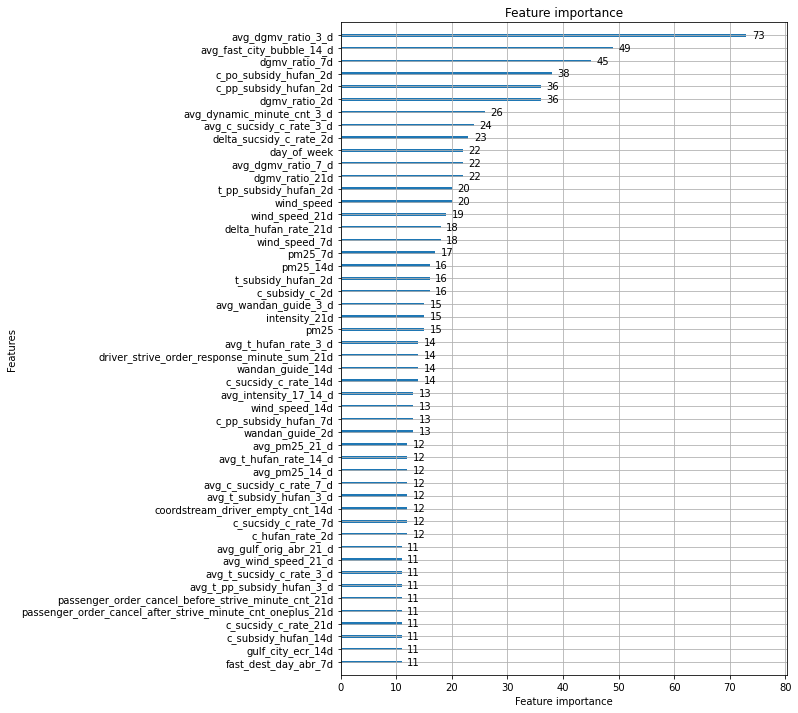

In [23]:
def cal_metric(test_y, test_pred, prefix=''):
    mae = np.mean(np.abs(test_y - test_pred))
    mape = np.mean(np.abs(test_y - test_pred) / np.maximum(np.abs(test_y), 0.01))
    rmse = np.sqrt(((test_pred - test_y) ** 2).mean())
    tau = sp.stats.kendalltau(test_y, test_pred)[0]
    rho = sp.stats.spearmanr(test_y, test_pred)[0]
    ndcg = ndcg_score(np.expand_dims(test_y, axis=0), np.expand_dims(test_pred, axis=0))
    print('{}\n rmse:{} \n mae:{} \n mape:{} \n tau:{} \n rho:{} \n ndcg:{}'.format(prefix, rmse, mae, mape, tau, rho, ndcg))
    
print(params)

true_train_b = bst.predict(train_x)
train_pred = true_train_b*df_train['log_hufan_rate_scale'].values/100
train_y = df_train['dgmv_ratio']
cal_metric(train_y, train_pred, prefix='train-pred')


true_test_b = bst.predict(test_x)
test_pred = true_test_b*df_test['log_hufan_rate_scale'].values/100
test_y = df_test['dgmv_ratio']
cal_metric(test_y, test_pred, prefix='test-pred')


fig,ax = plt.subplots(figsize=(8,12))
lgb.plot_importance(bst, ax=ax, max_num_features=50)

In [22]:
# feature importance
print("feature importance:")
list(enumerate(sorted(zip(col, bst.feature_importances_), key=lambda x: x[1], reverse=True)))

feature importance:


[(0, ('avg_dgmv_ratio_3_d', 73)),
 (1, ('avg_fast_city_bubble_14_d', 49)),
 (2, ('dgmv_ratio_7d', 45)),
 (3, ('c_po_subsidy_hufan_2d', 38)),
 (4, ('dgmv_ratio_2d', 36)),
 (5, ('c_pp_subsidy_hufan_2d', 36)),
 (6, ('avg_dynamic_minute_cnt_3_d', 26)),
 (7, ('avg_c_sucsidy_c_rate_3_d', 24)),
 (8, ('delta_sucsidy_c_rate_2d', 23)),
 (9, ('dgmv_ratio_21d', 22)),
 (10, ('avg_dgmv_ratio_7_d', 22)),
 (11, ('day_of_week', 22)),
 (12, ('wind_speed', 20)),
 (13, ('t_pp_subsidy_hufan_2d', 20)),
 (14, ('wind_speed_21d', 19)),
 (15, ('wind_speed_7d', 18)),
 (16, ('delta_hufan_rate_21d', 18)),
 (17, ('pm25_7d', 17)),
 (18, ('c_subsidy_c_2d', 16)),
 (19, ('t_subsidy_hufan_2d', 16)),
 (20, ('pm25_14d', 16)),
 (21, ('pm25', 15)),
 (22, ('intensity_21d', 15)),
 (23, ('avg_wandan_guide_3_d', 15)),
 (24, ('c_sucsidy_c_rate_14d', 14)),
 (25, ('wandan_guide_14d', 14)),
 (26, ('driver_strive_order_response_minute_sum_21d', 14)),
 (27, ('avg_t_hufan_rate_3_d', 14)),
 (28, ('wandan_guide_2d', 13)),
 (29, ('c_pp_s

In [ ]:
# 单天预测
pred_date = '2020-11-15'
pred_dates = list(pd.date_range(start=pred_date, periods=7).astype('str'))
print(pred_dates)

print("single day prediction")
dfToCombine = []
for date in pred_dates:    
    df_test_period_date = pd.read_csv('data/dgmv_data_gx_zhuan_test_{}.csv'.format(date), sep='\t')
    df_test_period_date = df_test_period_date[df_test_period_date['tdate']==date]
    dfToCombine.append(df_test_period_date)


df_test_period = pd.concat(dfToCombine, ignore_index=True, sort=False)
df_test_period = df_test_period[df_test_period['delta_gmv_ratio'].notnull()]
df_test_period = df_test_period[(df_test_period.delta_gmv_pp > 0) & (df_test_period.treat_subsidy_hufan_rate > 0.001)]
df_test_period['pred'] = bst.predict(df_test_period[feature_cols])/100.

# 单天预测误差(all)
test_y = df_test_period['delta_gmv_ratio']
test_pred = df_test_period['pred']
print(test_y.shape)

cal_metric(test_y, test_pred, 'pred')

In [ ]:
# infer 
rate_list = list(np.round(np.arange(0.001, 0.201, 0.001), 3))
city_id_list = list(df_feats['city_id'].unique())
multi_index = pd.MultiIndex.from_product([city_id_list,rate_list], names=['city_id', 'delta_hufan_rate'])
city_rate_df = pd.DataFrame(index=multi_index).reset_index()
print(df_feats.shape)
df_feats = pd.merge(city_rate_df,df_feats,on = ['city_id'],how = 'left')
print(df_feats.shape)
dfToCombine = []
df_feats['log_hufan_rate_scale'] = df_feats['delta_hufan_rate'].apply(lambda x: math.log(1000*x))
df_feats['pred_dgmv_ratio'] = bst.predict(df_feats[train_feature_list])*df_feats['log_hufan_rate_scale']/100.
dfToCombine.append(df_feats[['tdate', 'city_id', 'delta_hufan_rate', 'log_hufan_rate_scale', 'pred_dgmv_ratio']].copy())
df_pred = pd.concat(dfToCombine, ignore_index=True, sort=False)